In [1]:
alias qstat /opt/pbs/bin/qstat -u $USER

In [2]:
qstat

In [1]:
import os
import ase
import ase.calculators.vasp
import ase.io 
import ase.units
import ase.visualize
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import mywrapper

os.chdir('/home/ankit/dft_class/S23/D06')
pwd = os.getcwd()

In [2]:
atoms = ase.io.read('conventional.cif')
ase.visualize.view(atoms)  

In [6]:
os.chdir(pwd)

# get stress and forces from simple SCF calculations
atoms = ase.io.read('conventional.cif')
print("Original Lattice Vectors")
print(atoms.get_cell())

path = 'structure_relax/scf/'

# set basic calculator
calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[6,6,6],
            encut=300,
            ediff=1e-5,
            algo='fast',         # algo in vasp implemented in vasp, we can also add normal and vey fast , normal is robust
            prec='accurate',     # set some parameter like it will set encut by self , but specify on your own
            nelmin=4,            # minimum electronic/scf iterations
            nelm=100,            # maximum elecreonic/scf iterations
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2,                # how many parallel calculation you want in CPUs 
            )
    
atoms.set_calculator(calc)
energy = mywrapper.get_energy(atoms, dir=path)
calc = mywrapper.get_calculator(dir=path)

if calc is not None:
    atoms = calc.atoms
    print('Stress-Tensor (GPa): ', 
                      mywrapper.read_property(dir=path, property='stress')/ase.units.GPa)
    forces = mywrapper.read_property(dir=path, property='forces')
    print('\nAtomic-Symbol | position (A) | force (eV/A)')
    print('-'*45)
    for i, atom in enumerate(atoms):
        print(atom.symbol, atom.position, forces[i])   # forces shold we zero if atoms are not moving due to symmetry
    print("\nLattice-Vectors:\n", atoms.get_cell())

ase.visualize.view(atoms)    

Original Lattice Vectors
[[3.8 0.  0. ]
 [0.  3.8 0. ]
 [0.  0.  3.8]]
Stress-Tensor (GPa):  [14.580172 14.580172 14.580172 -0.       -0.        0.      ]

Atomic-Symbol | position (A) | force (eV/A)
---------------------------------------------
Cu [0. 0. 0.] [-0. -0. -0.]
Cu [0.  1.9 1.9] [0. 0. 0.]
Cu [1.9 0.  1.9] [-0. -0. -0.]
Cu [1.9 1.9 0. ] [-0.  0.  0.]

Lattice-Vectors:
 [[3.8 0.  0. ]
 [0.  3.8 0. ]
 [0.  0.  3.8]]


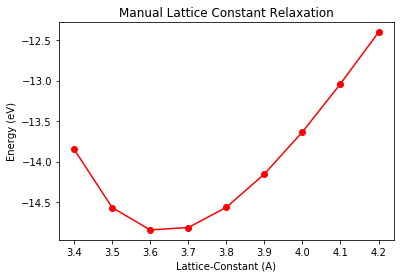

[-1.135942 -1.135942 -1.135942 -0.       -0.       -0.      ]
[21.197972 21.197972 21.197972 -0.       -0.       -0.      ]


In [6]:
# relax manually by setting the lattice-vectors

atoms = ase.io.read('conventional.cif')

alat = [x/10. for x in range(34,43)]
energies = []

# set basic calculator
calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[6,6,6],
            encut=300,
            ediff=1e-5,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2,             
            )

for a in alat:
    path = 'structure_relax/manual/%d' % (int(a*100))
                                         
    cell = [[a, 0, 0], [0, a, 0], [0, 0, a]]
    atoms.set_cell(cell, scale_atoms=True)
                                         
    atoms.set_calculator(calc)
    energy = mywrapper.get_energy(atoms, dir=path)
    energies.append(energy)              
                                                                            
plt.plot(alat, energies, 'ro-')
plt.xlabel('Lattice-Constant (A)')
plt.ylabel('Energy (eV)')
plt.title('Manual Lattice Constant Relaxation')
plt.show()

print(mywrapper.read_property(dir='structure_relax/manual/%d' % (int(3.6*100)), property='stress')/ase.units.GPa)
print(mywrapper.read_property(dir='structure_relax/manual/%d' % (int(4.2*100)), property='stress')/ase.units.GPa)

In [25]:
# relax atoms using vasp internal algo
# Note new-relaxation related parameters

atoms = ase.io.read('conventional.cif')
natom = len(atoms.get_positions())
path = 'structure_relax/vasp_relax/'

# set basic calculator
calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[6,6,6],
            encut=300,
            ediff=1e-5,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2,                
            
            # following are new relaxation-related parameets
            nsw=100,        # ionic movement maximum number of ionic step
            ibrion=2,       # 
            isif=3          # degree of freedom 
            ediffg=1e-4,  # criterion of 0.1 meV/atom change in energy 
            )
    
atoms.set_calculator(calc)
energy = mywrapper.get_energy(atoms, dir=path)
calc = mywrapper.get_calculator(dir=path)

if calc is not None:
    atoms = calc.atoms
    print('Stress-Tensor (GPa): ', calc.stress/ase.units.GPa)
    forces = calc.forces
    print('\nAtomic-Symbol | position (A) | force (eV/A)')
    print('-'*45)
    for i, atom in enumerate(atoms):
        print(atom.symbol, atom.position, forces[i])

    print("\nLattice-vectors:\n", atoms.get_cell())

Stress-Tensor (GPa):  [-0.063921 -0.063921 -0.063921 -0.        0.       -0.      ]

Atomic-Symbol | position (A) | force (eV/A)
---------------------------------------------
Cu [0. 0. 0.] [-0. -0. -0.]
Cu [0.         1.81503832 1.81503832] [-0.  0.  0.]
Cu [1.81503832 0.         1.81503832] [ 0.  0. -0.]
Cu [1.81503832 1.81503832 0.        ] [-0. -0. -0.]

Lattice-vectors:
 [[ 3.63007663  0.         -0.        ]
 [-0.          3.63007663  0.        ]
 [ 0.          0.          3.63007663]]


In [ ]:
# visualize relaxation
!ase gui structure_relax/vasp_relax/OUTCAR